<font size="6">Variational Inference - Latent Hurst Exponent States</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\large D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states' mean/covariances factorize, 

$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$

This notebook uses the above approach to look for significant shifts in the Hurst exponent, a measure of how the system behaves with respect to auto-correlation and long term time dependence. 

In [27]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

I will be testing with a small universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF using data from the <b>M6 Financial Forecasting</b> (https://m6competition.com/) competition sponsored by Google and others. The goal will be time series clustering using variational inference. Set num_components to a very high number since the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [28]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [29]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Hurst Function</font>

Install pyeeg for the hurst function, which will measure the long term time-dependence structure of the series. 

This notebook uses the above Variational inference approach to look for significant shifts in the Hurst exponent, a measure of how the system behaves with respect to auto-correlation and long term time dependence. This may be interesting because there are pockets of time, regimes, switching on/off latent states, where the Hurst exponent for one dimension of the time series is high while another dimension is low. In this context, it indicates that a certain asset is more 'trending' versus another, which might be behaving in a more mean-reverting fashion instead.

In [24]:
%pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-17ivy9mb
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-17ivy9mb
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


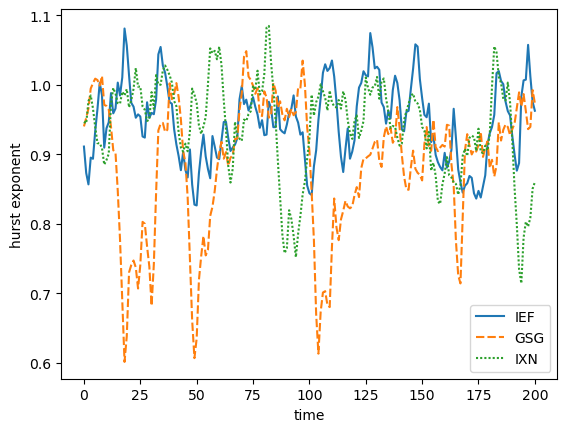

In [26]:
import scipy.stats as stats
import pyeeg 

m6_subset = m6_assets.copy()

# Window length 30 days
wlen = 30

# First convert to log price and then produce rolling mean window of the Hurst parameter
m6_subset = m6_subset.apply(np.log).rolling(wlen).apply(pyeeg.hurst)

# Clean data 
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

# View hurst parameter data 
sns.lineplot(m6_subset)
plt.xlabel('time')
plt.ylabel('hurst exponent')
plt.show()

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the most frequently occuring latent state discovered using np.argmax(). 

In [18]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=10, 
                                          max_iter=1000000)

In [19]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

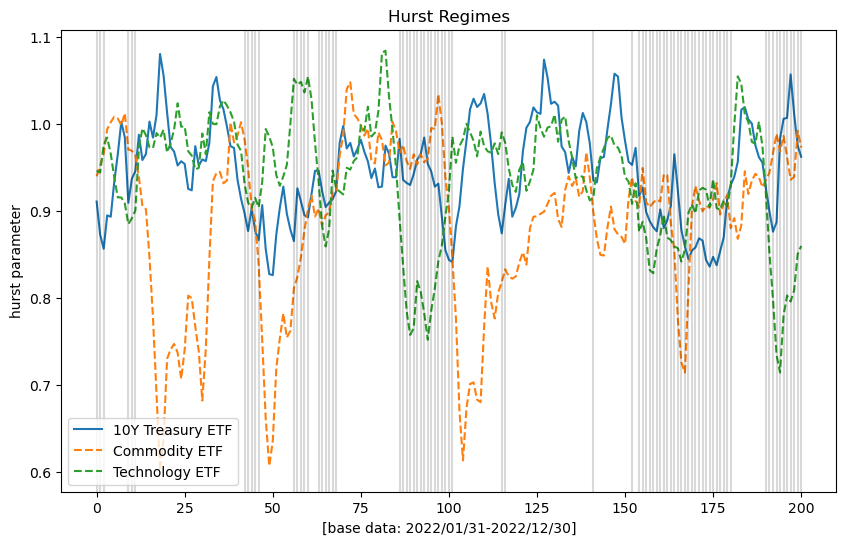

state_counts=
[ 0.  0.  0.  0.  0. 73. 48.  0. 80.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [20]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(x=m6_subset.index, y=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF')
sns.lineplot(x=m6_subset.index, y=m6_subset['GSG'], ax=ax, label='Commodity ETF', linestyle='--')
sns.lineplot(x=m6_subset.index, y=m6_subset['IXN'], ax=ax, label='Technology ETF', linestyle='--')

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Hurst Regimes')
ax.set_ylabel('hurst parameter')
ax.set_xlabel(f'[base data: 2022/01/31-2022/12/30]')
plt.show()

print('state_counts=')
print(state_counts)